# Experiments for the Master's Program in Business Informatics University of Mannheim
This notebook contains the experiments performed on the Course-Skill Graph and Two-Step Course Recommendation Algorithm for the Master's Program in Business Informatics at the University of Mannheim.

The notebook is divided into the following sections:
1. Imports
2. Experiments

## 1. Imports

In [1]:
import camelot
import pandas as pd
import tableExtraction as te
import graphCreation as gc
import re
import networkx as nx
import matplotlib.pyplot as plt
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import courseSuggestion as cs

G = nx.read_graphml("../04_Graph/CourseSkillGraph_Master.graphml")

## 2. Experiments
### 2.1 Course-Skill Graph
#### 2.1.1 Prerequisite Paths
This part contains the code used to derive the prerequisite paths.

In [2]:
#Count number of courses with prerequisite relationships

courses_with_simple_prerequisite = []
courses_with_complex_prerequisite = []
courses_with_simple_exclusive_prerequiste = []
courses_with_complex_exclusive_prerequiste = []

for node in G.nodes:
    if G.nodes[node].get("type") == "course":
        incoming_edges = G.in_edges(node)
        for edge in incoming_edges:
            if G.nodes[edge[0]].get("type") == "prerequisite" and G.edges[edge].get("weight") in [1,2] \
            and not node in courses_with_complex_prerequisite:
                courses_with_complex_prerequisite.append(node)
            elif G.nodes[edge[0]].get("type") == "prerequisite" and G.edges[edge].get("weight") == -1 \
            and not node in courses_with_complex_exclusive_prerequiste:
                courses_with_complex_exclusive_prerequiste.append(node)

for node in G.nodes:
    if G.nodes[node].get("type") == "course":
        incoming_edges = G.in_edges(node)
        for edge in incoming_edges:
            if G.nodes[edge[0]].get("type") == "course" and not node in courses_with_complex_prerequisite and G.edges[edge].get("weight") in [1,2] \
            and not node in courses_with_simple_prerequisite:
                courses_with_simple_prerequisite.append(node)
            elif G.nodes[edge[0]].get("type") == "course" and not node in courses_with_complex_prerequisite and G.edges[edge].get("weight") == -1 \
            and not node in courses_with_simple_exclusive_prerequiste:
                courses_with_simple_exclusive_prerequiste.append(node)


print("Simple prerequisite relationships: " + str(courses_with_simple_prerequisite) + "\n")
print("Complex prerequisite relationships: " + str(courses_with_complex_prerequisite) + "\n")
print("Courses with simple exclusive prerequisite relationships: " + str(courses_with_simple_exclusive_prerequiste) + "\n")
print("Courses with complex exclusive prerequisite relationships: " + str(courses_with_complex_exclusive_prerequiste) + "\n")


print("Amount of courses with simple or complex prerequisite relationship: " + str(len(courses_with_simple_prerequisite) + 
                                                                                   len(courses_with_complex_prerequisite)))


Simple prerequisite relationships: ['FIN 541 Corporate Finance I - Case Study (Capital Structure, Cost of Capital and Valuation)', 'FIN 605 Applied Portfolio Management', 'FIN 640 Corporate Finance II (Mergers, Acquisitions and Divestitures)', 'IS 513 Applied IT Management in the Digital Age', 'IS 613 Applied Project in Design Thinking and Lean Software Development', 'MKT 664 Brand Strategy Seminar', 'OPM 662 Business Analytics: Modeling and Optimization']

Complex prerequisite relationships: ['ACC 620 Accounting for Financial Instruments and Financial Institutions', 'ACC 626 Transaction Accounting', 'ACC 628 Selected Issues in IFRS Accounting', 'ACC 632 Konzernrechnungslegungspraxis', 'ACC 662 Private Equity: Due Diligence and Value Creation', 'ACC 670 Audit Theory', 'ACC 676 Case Studies on Consulting in Financial Services Firms', 'ACC 680 Disclosure Theory', 'FIN 620 Behavioral Finance', 'FIN 685 Topics in Financial Regulation', 'FIN 686 Topics in Sustainable Finance', 'IS 607 Digit

In [3]:
#Compute accumulated course -> skill edge weights of courses with prerequisite relationships

course_rewards = cs.getCourseRewards(G, cs.default_weights)
for course in courses_with_simple_prerequisite:
    print(course + ": " + str(course_rewards[course]))

for course in courses_with_complex_prerequisite:
    print(course + ": " + str(course_rewards[course]))

#for course in courses_with_simple_exclusive_prerequiste:
#    print(course + ": " + str(course_rewards[course]))

#for course in courses_with_complex_exclusive_prerequiste:
#    print(course + ": " + str(course_rewards[course]))

FIN 541 Corporate Finance I - Case Study (Capital Structure, Cost of Capital and Valuation): 0.001
FIN 605 Applied Portfolio Management: 0.001
FIN 640 Corporate Finance II (Mergers, Acquisitions and Divestitures): 0.002
IS 513 Applied IT Management in the Digital Age: 0.001
IS 613 Applied Project in Design Thinking and Lean Software Development: 0.002
MKT 664 Brand Strategy Seminar: 0.09410939691444582
OPM 662 Business Analytics: Modeling and Optimization: 0.1542343387470999
ACC 620 Accounting for Financial Instruments and Financial Institutions: 0.001
ACC 626 Transaction Accounting: 0.001
ACC 628 Selected Issues in IFRS Accounting: 0.001
ACC 632 Konzernrechnungslegungspraxis: 0.001
ACC 662 Private Equity: Due Diligence and Value Creation: 0.001
ACC 670 Audit Theory: 0.001
ACC 676 Case Studies on Consulting in Financial Services Firms: 0.001
ACC 680 Disclosure Theory: 0.001
FIN 620 Behavioral Finance: 0.001
FIN 685 Topics in Financial Regulation: 0.001
FIN 686 Topics in Sustainable Fin

In [4]:
#Count total number of courses

course_amount = 0
for node in G.nodes:
    if G.nodes[node].get("type") == "course":
        course_amount += 1

print("Amount of courses: " + str(course_amount) + "\n")

Amount of courses: 173



In [5]:
#Extract prerequisite paths

#Get all nodes that are potentially the starting point of a prerequisite path
starting_nodes = []

for node in G.nodes:
    if G.nodes[node].get("type") == "course":
        incoming_edges = G.in_edges(node)
        is_starting_node = True
        for edge in incoming_edges:
            if G.nodes[edge[0]].get("type") == "course" or G.nodes[edge[0]].get("type") == "prerequisite":
                is_starting_node = False
                break
        if is_starting_node:
            starting_nodes.append([node])

#Compute all prerequiste paths
cache = starting_nodes.copy()
prerequisite_paths = []
is_finished = False

while not is_finished:
    is_finished = True
    paths_to_delete = []
    new_paths = []
    for path in cache:
        path_is_finished = True
        last_node = path[len(path) - 1]
        outgoing_edges = G.out_edges(last_node)
        for edge in outgoing_edges:
                if (G.nodes[edge[1]].get("type") == "course" and G.edges[edge].get("weight") in [1,2]) or \
                    (G.nodes[edge[1]].get("type") == "prerequisite" and G.nodes[edge[1]].get("subtype") == "MIN" and 
                     G.edges[edge].get("weight") in [1,2]):
                    path_is_finished = False
                    new_path = path.copy()
                    new_path.append(edge[1])
                    new_paths.append(new_path)
                    if path not in paths_to_delete:
                        paths_to_delete.append(path)
        if path_is_finished:
            paths_to_delete.append(path)
            prerequisite_paths.append(path)
        else:
            is_finished = False
    for path_to_delete in paths_to_delete:
        cache.remove(path_to_delete)
    for new_path in new_paths:
        cache.append(new_path)

#Remove all paths that only consist of one node
prerequisite_paths_filtered = []
for prerequisite_path in prerequisite_paths:
    if len(prerequisite_path) > 1:
        prerequisite_paths_filtered.append(prerequisite_path)

prerequisite_paths = prerequisite_paths_filtered

for prerequisite_path in prerequisite_paths:
    print("Path:")
    print(prerequisite_path)

print("Number of prerequiste paths: " + str(len(prerequisite_paths)))

Path:
['IS 512 IT Management in the Digital Age', 'IS 513 Applied IT Management in the Digital Age']
Path:
['IS 615 Design Thinking and Lean Development in Enterprise Software Development', 'IS 613 Applied Project in Design Thinking and Lean Software Development']
Path:
['MKT 663 Branding and Brand Management', 'MKT 664 Brand Strategy Seminar']
Path:
['OPM 561 Production Management: Lean Approaches and Variability', 'OPM 662 Business Analytics: Modeling and Optimization']
Path:
['ACC 510 Jahresabschluss', 'MIN 0', 'ACC 620 Accounting for Financial Instruments and Financial Institutions']
Path:
['ACC 510 Jahresabschluss', 'MIN 1', 'ACC 662 Private Equity: Due Diligence and Value Creation']
Path:
['ACC 510 Jahresabschluss', 'MIN 2', 'ACC 670 Audit Theory']
Path:
['ACC 510 Jahresabschluss', 'MIN 3', 'ACC 676 Case Studies on Consulting in Financial Services Firms']
Path:
['ACC 510 Jahresabschluss', 'MIN 4', 'ACC 680 Disclosure Theory']
Path:
['ACC 520 IFRS Accounting and Capital Markets', 

In [6]:
#Calculate depth of prerequisite paths

for prerequisite_path in prerequisite_paths:
    depth = 0
    for course in prerequisite_path:
        if G.nodes[course].get("type") == "course":
            depth += 1
    prerequisite_path.append(depth)

depth = [0,0,0,0,0,0,0,0,0,0]

for prerequisite_path in prerequisite_paths:
    depth[prerequisite_path[len(prerequisite_path)-1]] += 1

print(depth)

[0, 0, 86, 17, 3, 0, 0, 0, 0, 0]


In [7]:
#Extract prerequiste paths with a depth greater than two

for prerequisite_path in prerequisite_paths:
    if len(prerequisite_path) > 3:
        print("Path:")
        print(prerequisite_path)

Path:
['ACC 510 Jahresabschluss', 'MIN 0', 'ACC 620 Accounting for Financial Instruments and Financial Institutions', 2]
Path:
['ACC 510 Jahresabschluss', 'MIN 1', 'ACC 662 Private Equity: Due Diligence and Value Creation', 2]
Path:
['ACC 510 Jahresabschluss', 'MIN 2', 'ACC 670 Audit Theory', 2]
Path:
['ACC 510 Jahresabschluss', 'MIN 3', 'ACC 676 Case Studies on Consulting in Financial Services Firms', 2]
Path:
['ACC 510 Jahresabschluss', 'MIN 4', 'ACC 680 Disclosure Theory', 2]
Path:
['ACC 520 IFRS Accounting and Capital Markets', 'MIN 0', 'ACC 620 Accounting for Financial Instruments and Financial Institutions', 2]
Path:
['ACC 520 IFRS Accounting and Capital Markets', 'MIN 1', 'ACC 662 Private Equity: Due Diligence and Value Creation', 2]
Path:
['ACC 520 IFRS Accounting and Capital Markets', 'MIN 2', 'ACC 670 Audit Theory', 2]
Path:
['ACC 520 IFRS Accounting and Capital Markets', 'MIN 3', 'ACC 676 Case Studies on Consulting in Financial Services Firms', 2]
Path:
['ACC 520 IFRS Accoun

#### 2.1.2 Visualization of Prerequiste Relationships
This part contains the code used to derive the visualization of prerequisite relationships.

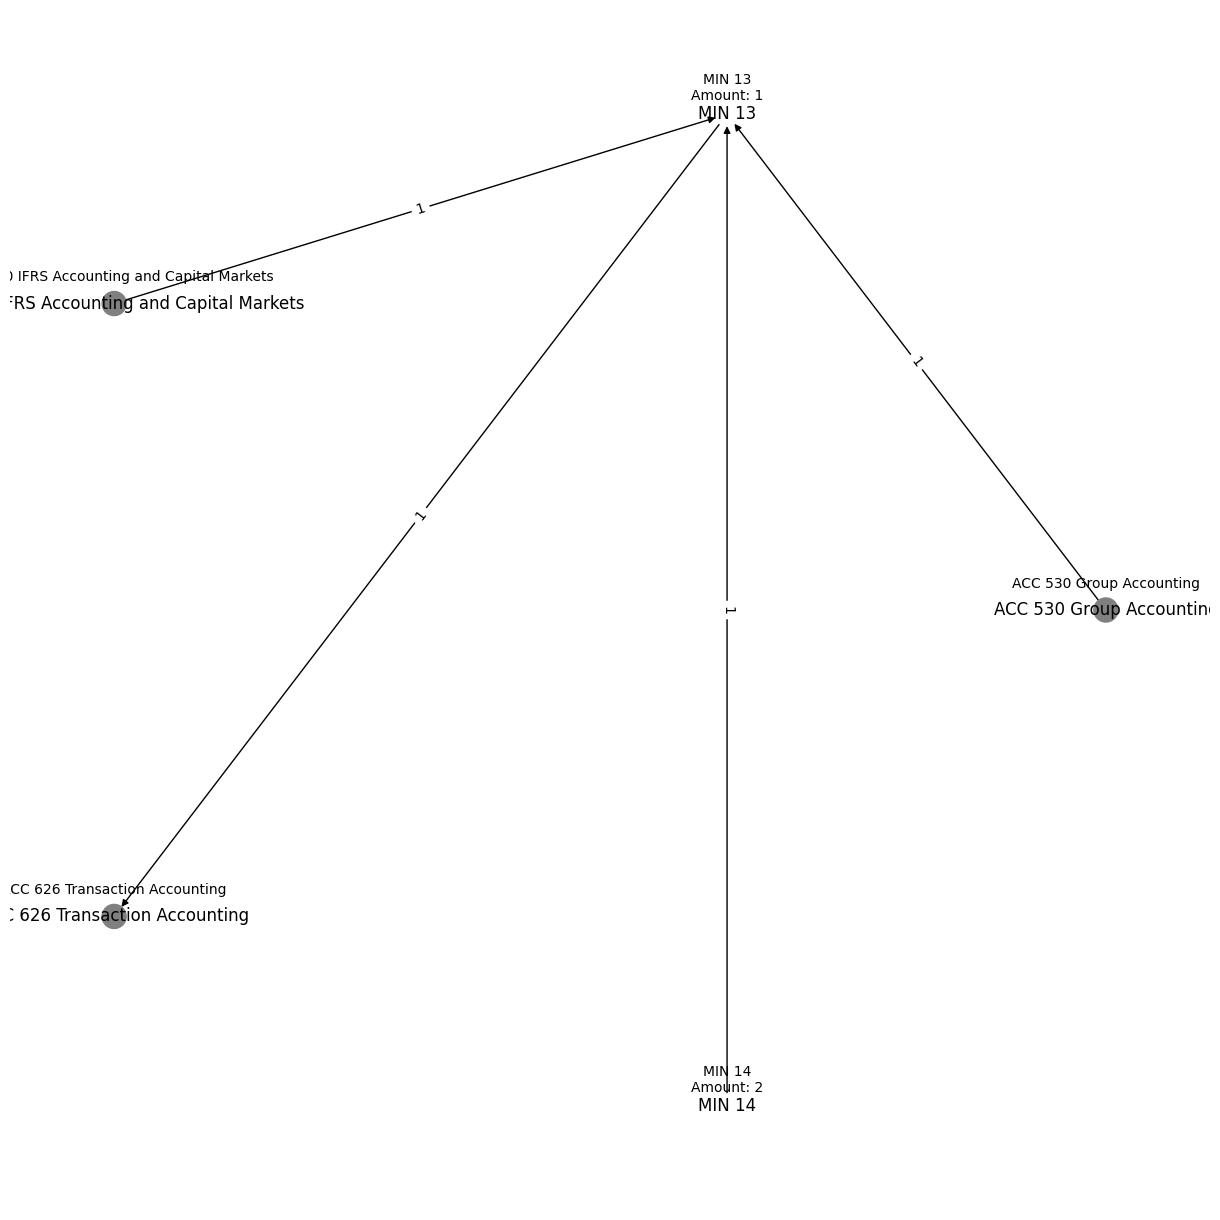

In [8]:
#Script for visualizing individual nodes

# Choose node
node_id = "MIN 14"
node_id = "MIN 13"
#node_id = "ACC 626 Transaction Accounting"
#node_id = "TP 500 Team Project Split 1"

#Get incoming and outgoing edges of the node
incoming_nodes = [n for n in G.predecessors(node_id) if G.nodes[n].get("type") in ["course","prerequisite"]]
outgoing_nodes = [n for n in G.successors(node_id) if G.nodes[n].get("type") in ["course","prerequisite"]]

#Uncomment the desired edges that should be included in the visualization
subgraph_nodes = set([node_id] + incoming_nodes + outgoing_nodes)
#subgraph_nodes = set([node_id] + outgoing_nodes)
#subgraph_nodes = set([node_id] + incoming_nodes)

#Create the plot
subgraph = G.subgraph(subgraph_nodes)
pos = nx.circular_layout(subgraph)
plt.figure(figsize=(12, 12))

node_colors = [subgraph.nodes[node]['color'] for node in subgraph.nodes()]
nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, font_size=12)
node_labels = {
    node: f"{node}\nAmount: {subgraph.nodes[node]['amount']}" 
    if 'amount' in subgraph.nodes[node] else node
    for node in subgraph.nodes()
}

offset = 0.05 
label_pos = {node: (pos[node][0], pos[node][1] + offset) for node in subgraph.nodes()}
nx.draw_networkx_labels(subgraph, label_pos, labels=node_labels, font_size=10)
edge_labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels)

plt.savefig("Outputs/Prerequisite_Visualization.pdf", format="pdf")
plt.show()

#### 2.1.3 Extraction of Key Courses
This part contains the code used to extract the key courses of the curriculum.

In [9]:
#Calculate the number and accumulated weight of the course -> skill and skill -> course edges of all course nodes

#List for skill -> course edges
incoming_skills = []
#List for course -> skill edges
outgoing_skills = []

for node in G.nodes:
    if G.nodes[node].get("type") == "course":
        incoming_edges = G.in_edges(node)
        count = 0
        weight = 0
        for edge in incoming_edges:
            if G.nodes[edge[0]].get("type") == "skill":
                count += 1
                weight += G.edges[edge].get("weight")
        incoming_skills.append([node, count, weight])
        
        outgoing_edges = G.out_edges(node)
        count = 0
        weight = 0
        for edge in outgoing_edges:
            if G.nodes[edge[1]].get("type") == "skill":
                count += 1
                weight += G.edges[edge].get("weight")
        outgoing_skills.append([node,count, weight])

In [10]:
#Get the courses with the highest number / accumulated weight of their course -> skill / skill -> course edges

#skill -> course edges
incoming_skills_counts = [x[1] for x in incoming_skills]
incoming_skills_weights = [x[2] for x in incoming_skills]

incoming_skills_counts_avg = sum(incoming_skills_counts) / len(incoming_skills_counts)
incoming_skills_weights_avg = sum(incoming_skills_weights) / len(incoming_skills_counts)

incoming_skills_counts_sorted = sorted(incoming_skills, key=lambda x: x[1], reverse = True)
incoming_skills_weights_sorted = sorted(incoming_skills, key=lambda x: x[2], reverse = True)

#course -> skill edges
outgoing_skills_counts = [x[1] for x in outgoing_skills]
outgoing_skills_weights = [x[2] for x in outgoing_skills]

outgoing_skills_counts_avg = sum(outgoing_skills_counts) / len(outgoing_skills_counts)
outgoing_skills_weights_avg = sum(outgoing_skills_weights) / len(outgoing_skills_counts)

outgoing_skills_counts_sorted = sorted(outgoing_skills, key=lambda x: x[1], reverse = True)
outgoing_skills_weights_sorted = sorted(outgoing_skills, key=lambda x: x[2], reverse = True)

print("Average incoming skills number: " + str(round(incoming_skills_counts_avg,3)))
print("Most incoming skills:")
for i in range(0, 5):
    print(incoming_skills_counts_sorted[i])

print("\nAverage outgoing skill number: " + str(round(outgoing_skills_counts_avg,3)))
print("Most outgoing skills:")
for i in range(0, 5):
    print(outgoing_skills_counts_sorted[i])

print("\nAverage incoming skill weight: " + str(round(incoming_skills_weights_avg,3)))
print("Highest incoming skill weights:")
for i in range(0, 5):
    print(incoming_skills_weights_sorted[i])

print("\nAverage outgoing skill weight: " + str(round(outgoing_skills_weights_avg,3)))
print("Highest outgoing skill weights:")
for i in range(0, 5):
    print(outgoing_skills_weights_sorted[i])

Average incoming skills number: 1.387
Most incoming skills:
['CS 704 Master Seminar Artificial Intelligence', 6, 1.2698939642797094]
['CS 530 Database Systems II (DBSII)', 5, 0.17776151105493132]
['CS 550 Algorithmics', 5, 0.09413817615694076]
['IE 500 Data Mining I', 5, 0.03592350639412465]
['IE 672 Data Mining II', 5, 1.1110605426119766]

Average outgoing skill number: 1.578
Most outgoing skills:
['TAX 620 Applied Empirical Research: Methods and Practical Implementation', 5, 0.005]
['IS 629 Agile Software Product Management and Design', 4, 0.2503837209302326]
['IS 722 Seminar: Context-Aware and Distributed Systems', 4, 1.5019320600928223]
['OPM 562 Business Analytics: Applications of Artificial Intelligence for Data-Driven Decision Making', 4, 0.004]
['IE 500 Data Mining I', 3, 0.5016070211948934]

Average incoming skill weight: 0.141
Highest incoming skill weights:
['IE 689 Relational Learning', 3, 1.8616144257725213]
['CS 701 Selected Topics in Algorithmics and Cryptography', 5, 1.

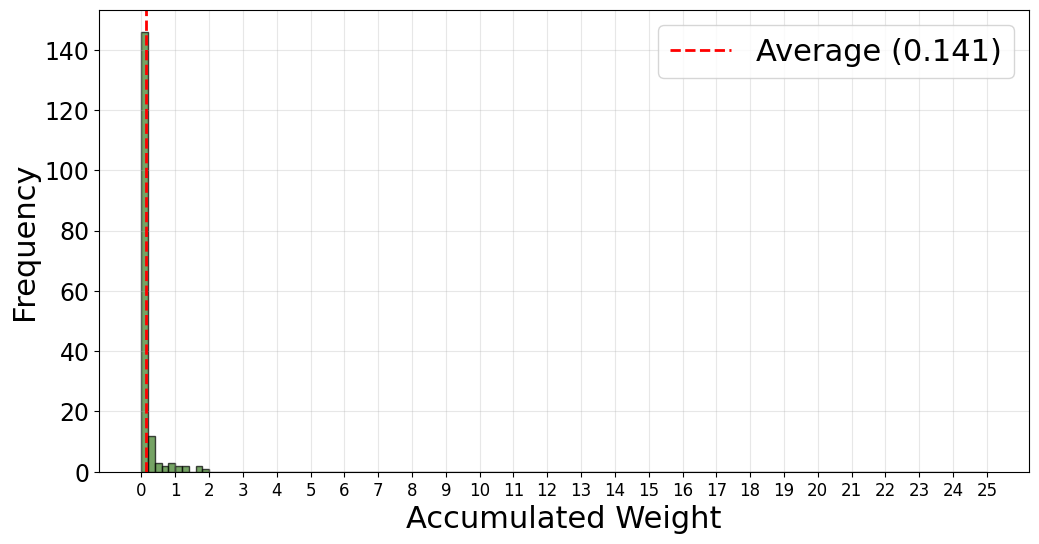

In [11]:
#Create Histogram of the distribution of the accumulated weights of all skill -> course edges

plt.figure(figsize=(12, 6))
bins = np.linspace(0, 25, 126)
counts, bin_edges, bars = plt.hist(incoming_skills_weights, bins=bins, color='#3B7D23', edgecolor='black', alpha=0.7)

#Add average
plt.axvline(incoming_skills_weights_avg, color='red', linestyle='dashed', linewidth=2, label=f'Average ({incoming_skills_weights_avg:.3f})')

#Add Labels
plt.xlabel('Accumulated Weight', fontsize=22)
plt.ylabel('Frequency', fontsize=22)
plt.legend(fontsize=22)
plt.xticks(np.arange(0, 26, 1), fontsize=12) 
plt.yticks(fontsize=17)
plt.grid(alpha=0.3)

#Show and export
plt.savefig('Outputs/AccumulatedIncomingSkillWeights_Master.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

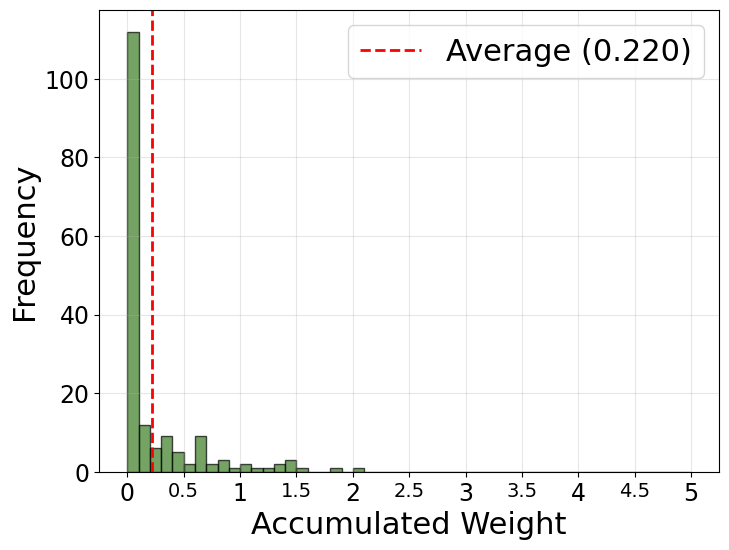

In [12]:
#Create Histogram of the distribution of the accumulated weights of all course -> skill edges

plt.figure(figsize=(8, 6))
bins = np.linspace(0, 5, 51)
counts, bin_edges, bars = plt.hist(outgoing_skills_weights, bins=bins, color='#3B7D23', edgecolor='black', alpha=0.7)

#Add average
plt.axvline(outgoing_skills_weights_avg, color='red', linestyle='dashed', linewidth=2, label=f'Average ({outgoing_skills_weights_avg:.3f})')

#Add Labels
plt.xlabel('Accumulated Weight', fontsize=22)
plt.ylabel('Frequency', fontsize=22)
plt.legend(fontsize=22)
xticks = np.arange(0, 5.5, 0.5)
xtick_labels = []

#Set different font size for integers and floats on x-axis
for tick in xticks:
    if tick.is_integer():
        xtick_labels.append(f'{int(tick)}') 
    else:
        xtick_labels.append(f'{tick:.1f}') 
xtick_fontsizes = [17 if tick.is_integer() else 14 for tick in xticks]
plt.xticks(xticks, labels=xtick_labels)
for label, size in zip(plt.gca().get_xticklabels(), xtick_fontsizes):
    label.set_fontsize(size)

plt.yticks(fontsize=17)
plt.grid(alpha=0.3)

#Show and export
plt.savefig('Outputs/HistogramAccumulatedOutgoingEdges_Master.png', format='png', dpi=300, bbox_inches='tight') 
plt.show()

### 2.2 Two-Step Course Recommendation Algorithm
#### 2.2.1 Greedy Selection & Optimization Phase
This part contains the code used to analyze the differences between the two phases of the Two-Step Course Recommendation Algorithm.

In [13]:
#Define the weight vector
default_weights = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

#Generate the study plans
greedy, final, iterations = cs.twoStepAlgo(G, 32, 120, default_weights, "FWS")
course_rewards = cs.getCourseRewards(G, default_weights)

#Print both study plans together with their rewards. Normalized rewards correspond to the rewards calculated based on the default weight vector
cs.printStudyPlan(G, greedy[0], "FWS")
print("Reward: " + str(cs.getPlanReward(G, greedy[0], "FWS", course_rewards)))
cs.printStudyPlan(G, final, "FWS")
print("Reward: " + str(cs.getPlanReward(G, final, "FWS", course_rewards)))
print("Iterations: " + str(iterations))

--------------------------------------------------------------
Semester 1:
['MKT 613 Verhandlungsführung', 'MKT 623 Strategic Marketing Management Simulation', 'IS 722 Seminar: Context-Aware and Distributed Systems', 'MKT 580 Digital Marketing Strategy', 'MAN 679 Eine wissenschaftliche Einführung in das Public und Nonprofit Management', 'IE 670 Web Data Integration', 'IS 540 Management of Enterprise Systems', 'FIN 604 Stata in Finance']
ECTS: 31
Semester 2:
['IE 691 Information Retrieval Project', 'CS 530 Database Systems II (DBSII)', 'IE 684 Web Mining Project', 'IE 671 Web Mining', 'IS 629 Agile Software Product Management and Design', 'IE 674 Hot Topics in Machine Learning', 'SQ 500 Scientific Research', 'IE 663 Information Retrieval and Web Search']
ECTS: 32
Semester 3:
['CS 560 Large-Scale Data Management', 'TP 500 Team Project Full', 'IE 500 Data Mining I', 'IE 683 Web Data Integration Project']
ECTS: 27
Semester 4:
['MA 650 Master Thesis']
ECTS: 30
------------------------------

In [14]:
#Analyze differences between the actual and recommended skill level for a course in context of its accumulated course -> skill edge weight

#print "Course Name: (actual skill level - recommended skill level), accumulated course -> skill edge weight"
cs.printSkillDiff(G, greedy[0], "FWS", course_rewards)
print("---------------------------------------------------")
cs.printSkillDiff(G, final, "FWS", course_rewards)

Semester: 1
MKT 613 Verhandlungsführung: 0, 1.4327548746518097
MKT 613 Verhandlungsführung: 0, 0
MKT 623 Strategic Marketing Management Simulation: 0.0, 1.3850767085076712
MKT 623 Strategic Marketing Management Simulation: 0, 0.0
IS 722 Seminar: Context-Aware and Distributed Systems: 0, 1.5019320600928223
IS 722 Seminar: Context-Aware and Distributed Systems: 0, 0
MKT 580 Digital Marketing Strategy: 0, 0.9078212290502796
MKT 580 Digital Marketing Strategy: 0, 0
MAN 679 Eine wissenschaftliche Einführung in das Public und Nonprofit Management: 0.0, 0.7916518010291594
MAN 679 Eine wissenschaftliche Einführung in das Public und Nonprofit Management: 0, 0.0
IE 670 Web Data Integration: 0, 0.107292808219178
IE 670 Web Data Integration: 0, 0
IS 540 Management of Enterprise Systems: 0, 0.1789734890868559
IS 540 Management of Enterprise Systems: 0, 0
FIN 604 Stata in Finance: 0, 0.003
FIN 604 Stata in Finance: 0, 0
Semester: 2
IE 691 Information Retrieval Project: 0.0, 0.4002627730408441
IE 691

#### 2.2.2 Impact of the Weight Vector
This part contains the code used to analyze the impact of the weight vector on the Two-Step Course Recommendation Algorithm.

In [15]:
#Define the weight vector
weights = [1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1]

#Generate the study plans
greedy, final, iterations = cs.twoStepAlgo(G, 32, 120, weights, "FWS")
course_rewards = cs.getCourseRewards(G, weights)

#Print both study plans together with their rewards. Normalized rewards correspond to the rewards calculated based on the default weight vector
cs.printStudyPlan(G, greedy[0], "FWS")
print("Reward: " + str(cs.getPlanReward(G, greedy[0], "FWS", course_rewards)))
cs.printStudyPlan(G, final, "FWS")
print("Reward: " + str(cs.getPlanReward(G, final, "FWS", course_rewards)))
print("Iterations: " + str(iterations))

--------------------------------------------------------------
Semester 1:
['MKT 613 Verhandlungsführung', 'MKT 623 Strategic Marketing Management Simulation', 'IS 722 Seminar: Context-Aware and Distributed Systems', 'MAN 635 Social Entrepreneurship: Targeting Social Capital through Ecopreneurship', 'MAN 656 Mergers & Acquisitions', 'IE 670 Web Data Integration', 'IE 650 Semantic Web Technologies', 'FIN 604 Stata in Finance']
ECTS: 31
Semester 2:
['CS 530 Database Systems II (DBSII)', 'IE 691 Information Retrieval Project', 'IE 671 Web Mining', 'IE 674 Hot Topics in Machine Learning', 'IE 684 Web Mining Project', 'IE 630 Query Optimization', 'SQ 500 Scientific Research', 'IE 663 Information Retrieval and Web Search']
ECTS: 32
Semester 3:
['CS 560 Large-Scale Data Management', 'TP 500 Team Project Full', 'CS 500 Advanced Software Engineering', 'IE 683 Web Data Integration Project']
ECTS: 27
Semester 4:
['MA 650 Master Thesis']
ECTS: 30
---------------------------------------------------

In [16]:
#Analyze differences between the actual and recommended skill level for a course in context of its accumulated course -> skill edge weight

#Prints two rows for each course:
#1. "Course Name: (actual skill level - recommended skill level), accumulated course -> skill edge weight"
#2. "Course Name: actual skill level, recommended skill level"
cs.printSkillDiff(G, greedy[0], "FWS", course_rewards)
print("---------------------------------------------------")
cs.printSkillDiff(G, final, "FWS", course_rewards)

Semester: 1
MKT 613 Verhandlungsführung: 0, 1.4337548746518098
MKT 613 Verhandlungsführung: 0, 0
MKT 623 Strategic Marketing Management Simulation: 0.0, 1.3850767085076712
MKT 623 Strategic Marketing Management Simulation: 0, 0.0
IS 722 Seminar: Context-Aware and Distributed Systems: 0, 2.0068109295410053
IS 722 Seminar: Context-Aware and Distributed Systems: 0, 0
MAN 635 Social Entrepreneurship: Targeting Social Capital through Ecopreneurship: 0, 1.5490291262135925
MAN 635 Social Entrepreneurship: Targeting Social Capital through Ecopreneurship: 0, 0
MAN 656 Mergers & Acquisitions: 0, 1.3373493975903614
MAN 656 Mergers & Acquisitions: 0, 0
IE 670 Web Data Integration: 0, 0.319878424657534
IE 670 Web Data Integration: 0, 0
IE 650 Semantic Web Technologies: 0.0, 0.36720915926178943
IE 650 Semantic Web Technologies: 0, 0.0
FIN 604 Stata in Finance: 0, 0.005
FIN 604 Stata in Finance: 0, 0
Semester: 2
CS 530 Database Systems II (DBSII): -0.030350038488252518, 2.5379100453449888
CS 530 Data